In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #Ploting
import seaborn as sns #Ploting
from sklearn.model_selection import KFold
import lightgbm as lgb

In [6]:
train = pd.read_csv('./data/clean/clean.csv')
test = pd.read_csv('./data/src/diamonds_test.csv')
train.rename(columns={'Unnamed: 0':'id'},inplace=True)
test.rename(columns={'Unnamed: 0':'id'},inplace=True)

train.head()

,id,price,carat,depth,table,x,y,z,cut,color,clarity,city
0,0,4268,1.21,62.4,58.0,6.83,6.79,4.25,Premium,J,VS2,Dubai
1,1,505,0.32,63.0,57.0,4.35,4.38,2.75,Very Good,H,VS2,Kimberly
2,2,2686,0.71,65.5,55.0,5.62,5.53,3.65,Fair,G,VS1,Las Vegas
3,3,738,0.41,63.8,56.0,4.68,4.72,3.00,Good,D,SI1,Kimberly
4,4,4882,1.02,60.5,59.0,6.55,6.51,3.95,Ideal,G,SI1,Dubai


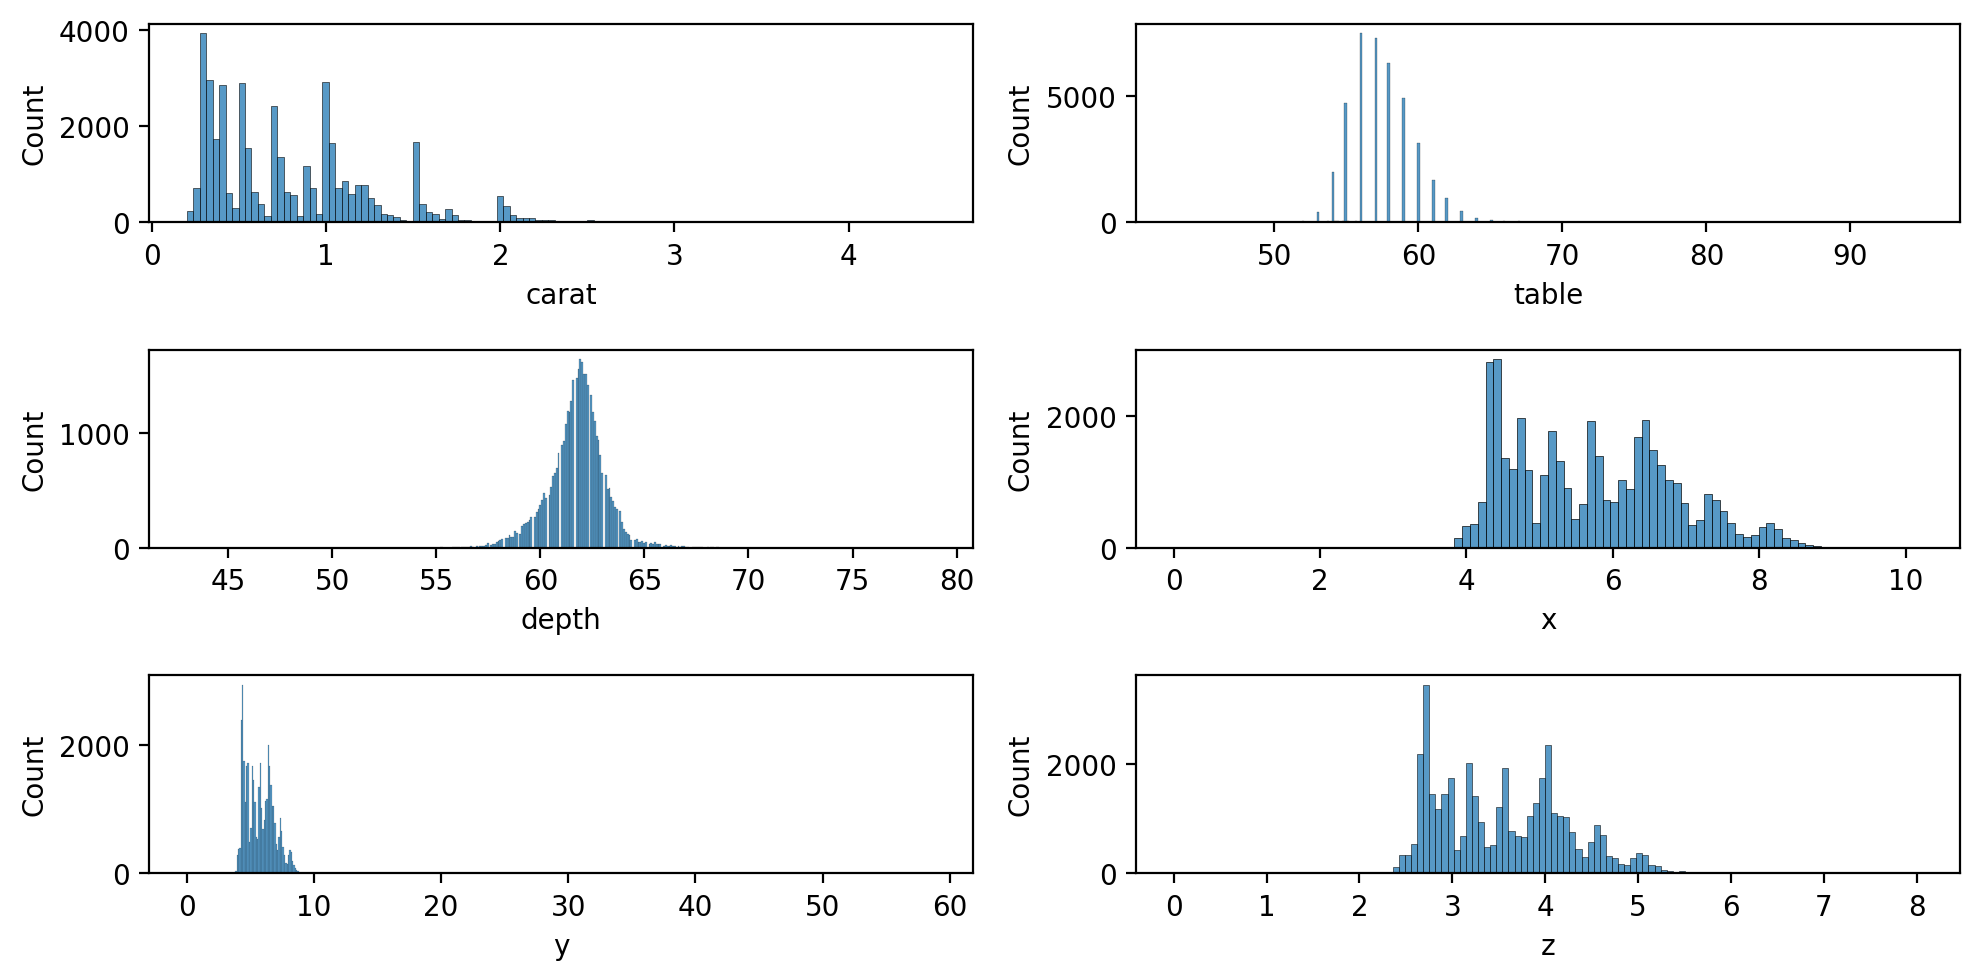

In [7]:
fig, ax_arr = plt.subplots(3,2, figsize=(10,5),dpi=200)
sns.histplot(train['carat'],ax = ax_arr[0][0])
sns.histplot(train['table'],ax = ax_arr[0][1])
sns.histplot(train['depth'],ax = ax_arr[1][0])
sns.histplot(train['x'],ax = ax_arr[1][1])
sns.histplot(train['y'],ax = ax_arr[2][0])
sns.histplot(train['z'],ax = ax_arr[2][1])
plt.tight_layout()

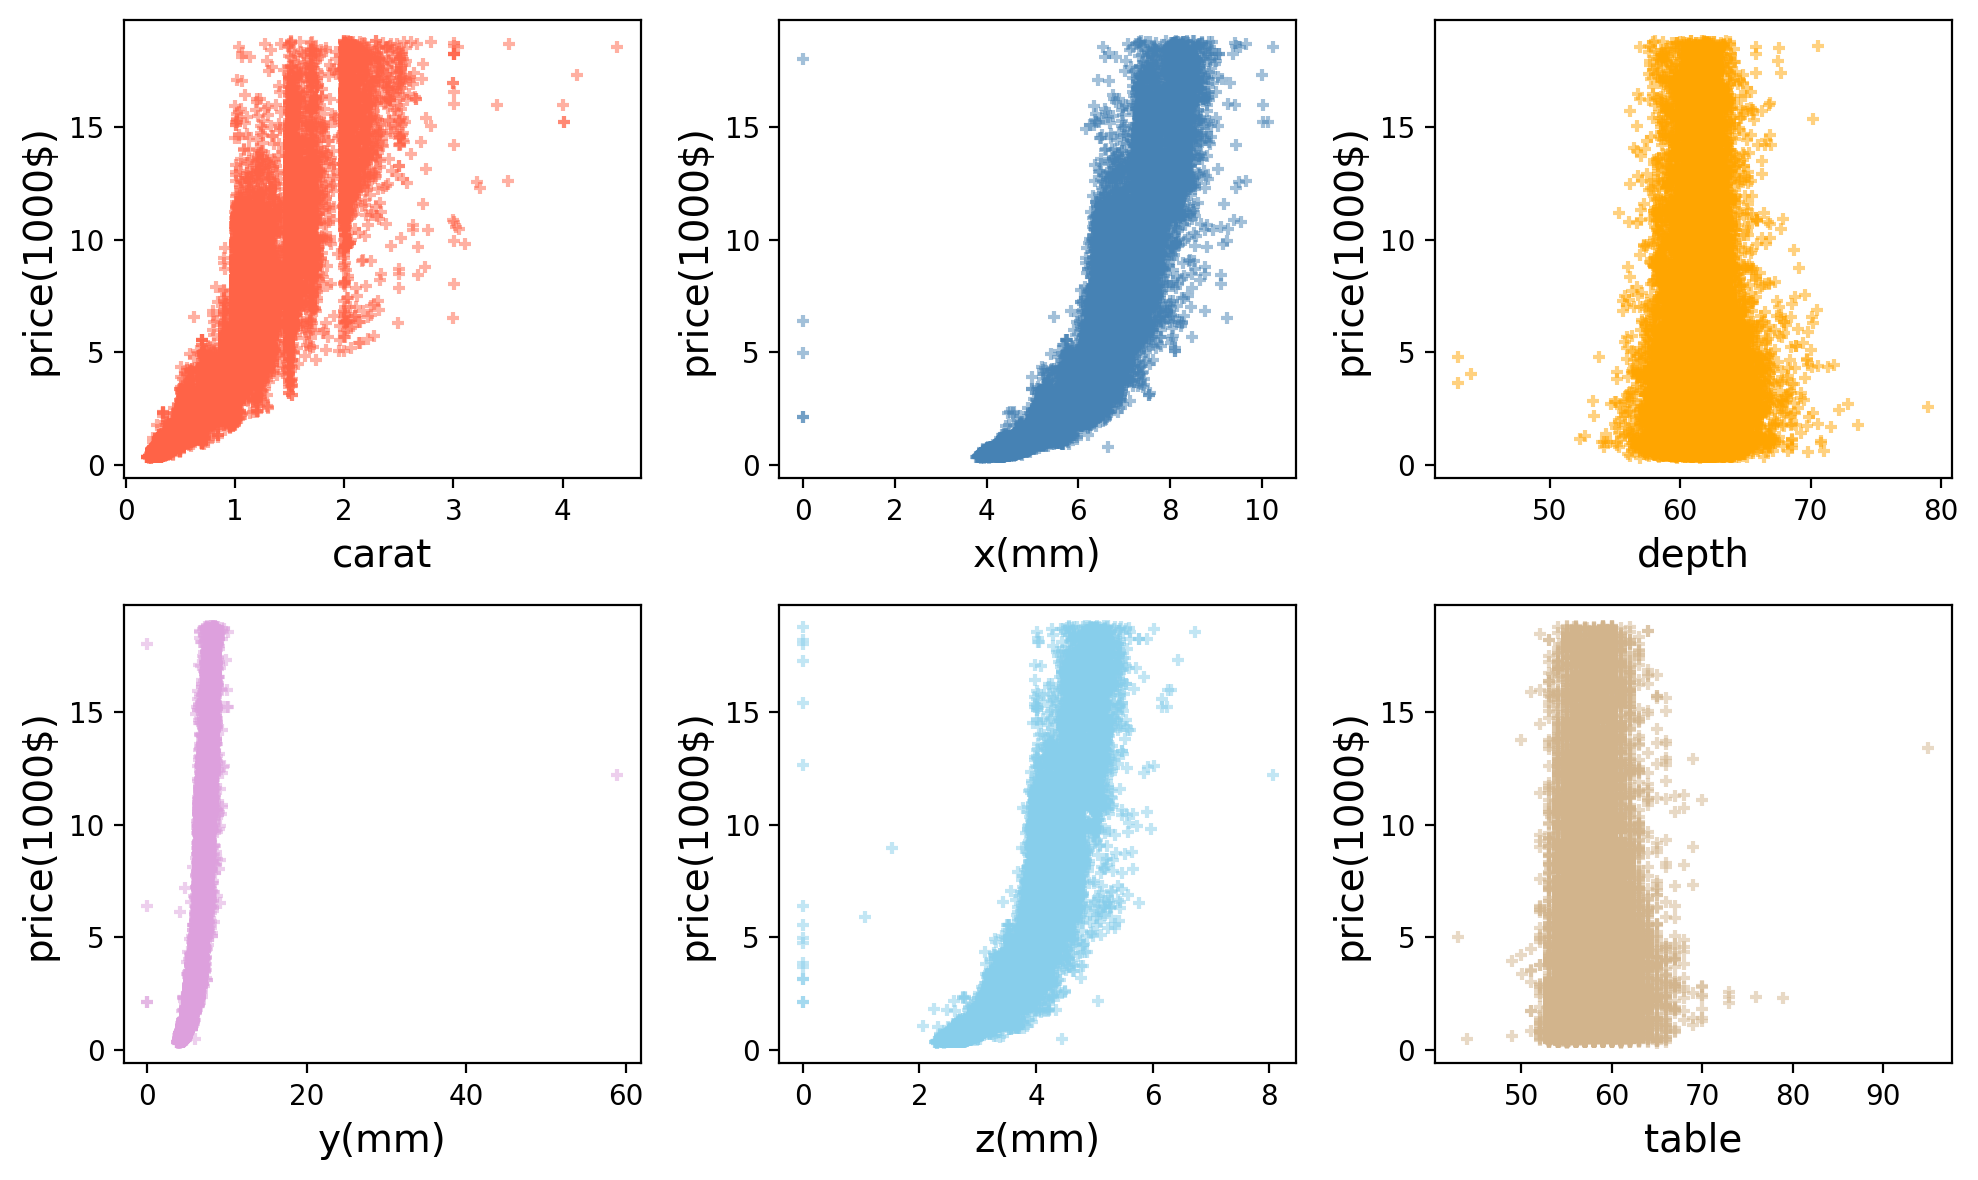

In [8]:
fig, ax_arr = plt.subplots(2,3, figsize=(10,6),dpi=200)
ax1 = ax_arr[0][0]
ax1.scatter(train['carat'],train['price']/1000,marker='+',color='tomato',alpha=0.5,s=20)
ax1.set_xlabel('carat',size=14)
ax1.set_ylabel('price(1000$)',size=14)

ax2 = ax_arr[0][1]
ax2.scatter(train['x'],train['price']/1000,marker='+',color='steelblue',alpha=0.5,s=20)
ax2.set_xlabel('x(mm)',size=14)
ax2.set_ylabel('price(1000$)',size=14)

ax3 = ax_arr[1][0]
ax3.scatter(train['y'],train['price']/1000,marker='+',color='plum',alpha=0.5,s=20)
ax3.set_xlabel('y(mm)',size=14)
ax3.set_ylabel('price(1000$)',size=14)

ax4 = ax_arr[1][1]
ax4.scatter(train['z'],train['price']/1000,marker='+',color='skyblue',alpha=0.5,s=20)
ax4.set_xlabel('z(mm)',size=14)
ax4.set_ylabel('price(1000$)',size=14)

ax5 = ax_arr[0][2]
ax5.scatter(train['depth'],train['price']/1000,marker='+',color='orange',alpha=0.5,s=20)
ax5.set_xlabel('depth',size=14)
ax5.set_ylabel('price(1000$)',size=14)

ax6 = ax_arr[1][2]
ax6.scatter(train['table'],train['price']/1000,marker='+',color='tan',alpha=0.5,s=20)
ax6.set_xlabel('table',size=14)
ax6.set_ylabel('price(1000$)',size=14)

plt.tight_layout()

In [9]:
y_err = train[train['y']>10]
idy = list(y_err['id'])
for i in idy:
    train.loc[i,'y'] = train.loc[i,'x']


# Cleaning...Round 2, to fill the missing value with 'x' or 'y' != 0.
z0 = train[train['z']==0]
idz = list(z0['id'])
for i in idz:
    if (train.loc[i,'x'] == 0 or train.loc[i,'y'] == 0):
        if (train.loc[i,'x'] == 0 and train.loc[i,'y'] == 0):
            pass
        else:
            temp = max(train.loc[i,'x'], train.loc[i,'y'])
            train.loc[i,'x'] = temp
            train.loc[i,'y'] = temp
    temp = train.loc[i,'depth']*(train.loc[i,'x'] + train.loc[i,'y'])/2/100
    train.loc[i,'z'] = temp

# Cleaning...Round 3, to fill the missing value with both 'x' and 'y' == 0. 

# Use curve_fit function to fill the missing 'x', 'y' and 'z'.
from scipy.optimize import curve_fit
def func(x, a, b):
    return a*pow(x, b)
popt, pcov = curve_fit(func,train['carat'],train['x'])
ax = popt[0]
bx = popt[1]
popt, pcov = curve_fit(func,train['carat'],train['y'])
ay= popt[0]
by = popt[1]

popt, pcov = curve_fit(func,train['z'],train['price'])
ap= popt[0]
bp = popt[1]

z0 = train[train['z']==0]
idz = list(z0['id'])


for i in idz:
    carat = train.loc[i,'carat']
    train.loc[i,'x'] = func(carat, ax, bx)
    train.loc[i,'y'] = func(carat, ay, by)
    temp = train.loc[i,'depth']*(train.loc[i,'x'] + train.loc[i,'y'])/2/100
    train.loc[i,'z'] = temp

In [10]:
cut = {'Fair':1,'Good':np.sqrt(2),'Very Good':np.sqrt(3),
       'Premium':np.sqrt(4),'Ideal':np.sqrt(5)}
color = {'D':np.sqrt(7),'E':np.sqrt(6),'F':np.sqrt(5),
         'G':np.sqrt(4),'H':np.sqrt(3),'I':np.sqrt(2),'J':1}
clarity = {'I1':1,'SI2':np.sqrt(2),'SI1':np.sqrt(3),
           'VS2':np.sqrt(4),'VS1':np.sqrt(5),'VVS2':np.sqrt(6),
           'VVS1':np.sqrt(7),'IF':np.sqrt(8)}

In [11]:
for i in range(0,train.shape[0]):
    train.loc[i,'cut'] = cut[train.loc[i,'cut']]
    train.loc[i,'color'] = color[train.loc[i,'color']]
    train.loc[i,'clarity'] = clarity[train.loc[i,'clarity']]
    if (i%1000==0):
        print('Encoding the train data,',i/train.shape[0]*100, '%')

for i in range(0,test.shape[0]):
    test.loc[i,'cut'] = cut[test.loc[i,'cut']]
    test.loc[i,'color'] = color[test.loc[i,'color']]
    test.loc[i,'clarity'] = clarity[test.loc[i,'clarity']]
    if (i%1000==0):
        print('Encoding the test data,',i/test.shape[0]*100, '%')

Encoding the train data, 0.0 %
Encoding the train data, 2.4718823384006923 %
Encoding the train data, 4.9437646768013845 %
Encoding the train data, 7.415647015202076 %
Encoding the train data, 9.887529353602769 %
Encoding the train data, 12.35941169200346 %
Encoding the train data, 14.831294030404152 %
Encoding the train data, 17.303176368804845 %
Encoding the train data, 19.775058707205538 %
Encoding the train data, 22.246941045606228 %
Encoding the train data, 24.71882338400692 %
Encoding the train data, 27.190705722407614 %
Encoding the train data, 29.662588060808304 %
Encoding the train data, 32.134470399209 %
Encoding the train data, 34.60635273760969 %
Encoding the train data, 37.07823507601038 %
Encoding the train data, 39.550117414411076 %
Encoding the train data, 42.021999752811766 %
Encoding the train data, 44.493882091212456 %
Encoding the train data, 46.96576442961315 %
Encoding the train data, 49.43764676801384 %
Encoding the train data, 51.90952910641453 %
Encoding the tr

In [12]:
def Norm(x):
    mi = np.mean(x)
    ma = np.std(x)
    return (x-mi)/ma

# Data Reshaping...
all_data = pd.concat((train,test))
all_data = all_data.drop(['id'],axis=1)

all_data['cd'] = Norm(all_data['table']*all_data['depth']/all_data['carat'])
all_data['xyzc'] = Norm(all_data['x']*all_data['y']*all_data['z']/
                        all_data['carat'])

all_data['xy'] = Norm((all_data['x']/all_data['y']))

all_data['xy2'] = Norm((all_data['x']/all_data['y'])**2)

all_data['td'] = Norm(all_data['depth']/all_data['table'])

all_data['depth'] = Norm(all_data['depth']) 
all_data['table'] = Norm(all_data['table'])

all_data['cut'] = all_data['cut'].astype('float32')
all_data['color'] =all_data['color'].astype('float32')
all_data['clarity'] = all_data['clarity'].astype('float32')


all_data['ctca'] = Norm(all_data['cut']*all_data['color'])
all_data['cyca'] = Norm(all_data['clarity']*all_data['color'])
all_data['crca'] = Norm(all_data['color']*all_data['cut'])

all_data['ctyr'] = Norm(all_data['cut']*all_data['color']*all_data['clarity'])

all_data['cut'] = Norm(all_data['cut'])
all_data['color'] = Norm(all_data['color'])
all_data['clarity'] = Norm(all_data['clarity'])


all_data['carat'] = Norm(all_data['carat']**2)
all_data['x'] = Norm(all_data['x']**2)
all_data['y'] = Norm(all_data['y']**2)
all_data['z'] = Norm(all_data['z']**2)

In [13]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
X_train = X_train.drop(['price'],axis=1)
X_test = X_test.drop(['price'],axis=1)
y = train['price']
X_train.head()

,carat,depth,table,x,y,z,cut,color,clarity,city,cd,xyzc,xy,xy2,td,ctca,cyca,crca,ctyr
0,0.570479,0.454133,0.242928,0.935512,0.858451,0.753516,0.156757,-2.390416,0.071559,Dubai,-0.937001,-0.045073,0.583083,0.563036,-0.013206,-1.850736,-1.707792,-1.850736,-1.400214
1,-0.718403,0.872950,-0.204605,-1.132898,-1.071406,-0.817577,-0.703482,-0.727509,0.071559,Kimberly,1.488742,0.040036,-0.568991,-0.556527,0.537688,-0.928976,-0.483867,-0.928976,-0.690322
2,-0.338184,2.618019,-1.099672,-0.188311,-0.254398,0.044279,-3.053699,-0.118842,0.648868,Las Vegas,-0.323147,-0.358589,1.522066,1.486077,2.142451,-1.850736,0.358806,-1.850736,-1.232632
3,-0.656216,1.431372,-0.652139,-0.910595,-0.849599,-0.602487,-1.723885,1.348029,-0.583717,Kimberly,0.749676,-0.171565,-0.715959,-0.698321,1.175175,-0.245346,0.451129,-0.245346,-0.519685
4,0.169437,-0.872119,0.690462,0.656028,0.591480,0.385431,0.914643,-0.118842,-0.583717,Dubai,-0.787157,0.179800,0.605995,0.585446,-0.958278,0.427980,-0.483867,0.427980,-0.070599


In [14]:
folds = KFold(n_splits=20, shuffle=True, random_state=2300)
params = {'num_leaves':64,
          'min_child_samples':6,
          'objective':'regression',
          'learning_rate':0.01,
          'boosting_type':'gbdt',
          'metric':'rmse',
          'max_depth':6,
          'verbose': -1}

i1=0
for trn_idx, val_idx in folds.split(X_train, y):
    i1 += 1
    trn_df, trn_label = X_train.iloc[trn_idx,:], y[trn_idx]
    val_df, val_label = X_train.iloc[val_idx,:], y[val_idx]
    dtrn = lgb.Dataset(trn_df,label=trn_label)
    dval = lgb.Dataset(val_df,label=val_label)
    bst = lgb.train(params,dtrn,num_boost_round=1000,valid_sets=[dtrn,dval],
                    early_stopping_rounds=200,verbose_eval=100)
    print('-------------------',i1,'---------------------')

TypeError: train() got an unexpected keyword argument 'early_stopping_rounds'